# **Model and Evaluation**

## Objectives

* Answer Business Requirement 2: Develop an ML model that classifies leaf images into these two categories; healthy or containing powdery mildew.

## Inputs

* inputs/cherryleaves_dataset/cherry-leaves/test
* inputs/cherryleaves_dataset/cherry-leaves/train
* inputs/cherryleaves_dataset/cherry-leaves/validation
* image shape embeddings.

```plaintext
├── inputs
│ └── cherryleaves_dataset
│ └── cherry-leaves
│   ├── test
│   │ ├── healthy
│   │ └── powdery_mildew
│   ├── train
│   │ ├── healthy
│   │ └── powdery_mildew
│   └── validation
│   │ ├── healthy
│   │ └── powdery_mildew
└── ...
``` 

## Outputs

* Image distribution plot in train, validation, and test set
* Image augementation for each set
* Class indices to change prediction inference in labels
* Creation of an ML model
* Display ML model summary
* Train ML model
* Save ML model
* Create Learning Curve Plot for model performance
* Model Evaluation on pickle file; determine accuracy, plot ROC curve, and calculate classification report 
* Plot Confusion Matrix
* Prediction on the random image file


---

# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

---

# Set working directory

In [2]:
cwd = os.getcwd()

In [4]:
os.chdir('/workspace/mildew-detector')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

---

## Set input directories
Set train, validation and test paths

In [6]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set label names

In [8]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set image shape

In [9]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Images distribution

These plots will give you a comprehensive view of your dataset's distribution across different labels and sets, which is essential for understanding data balance and preparing for model training.

## Count number of images per set and label

In [10]:
import plotly.express as px

df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Count': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images




## Label Distribution

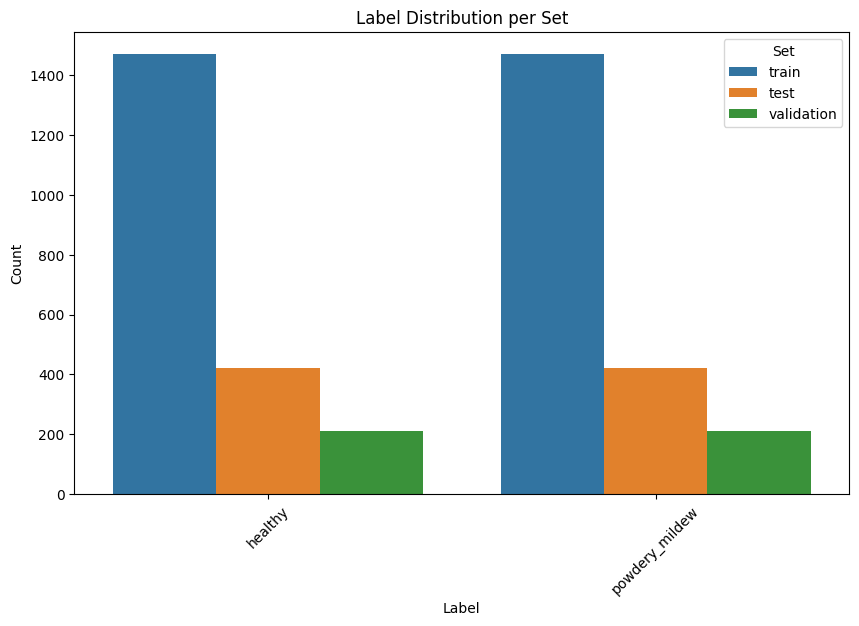

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_freq, x='Label', y='Count', hue='Set')
plt.title('Label Distribution per Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Set')
plt.show()

## Set Distribution

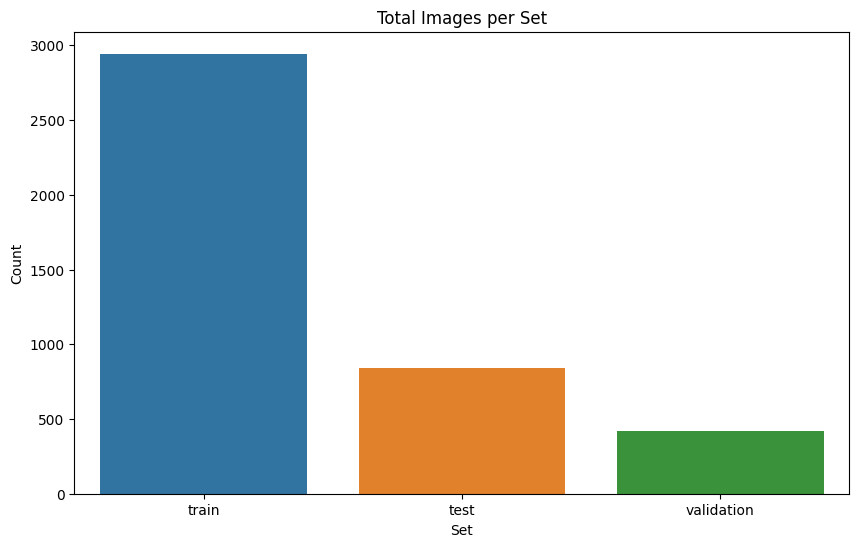

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_freq, x='Set', y='Count', estimator=sum, ci=None)
plt.title('Total Images per Set')
plt.xlabel('Set')
plt.ylabel('Count')
plt.show()

## Set and Label Combined Distribution

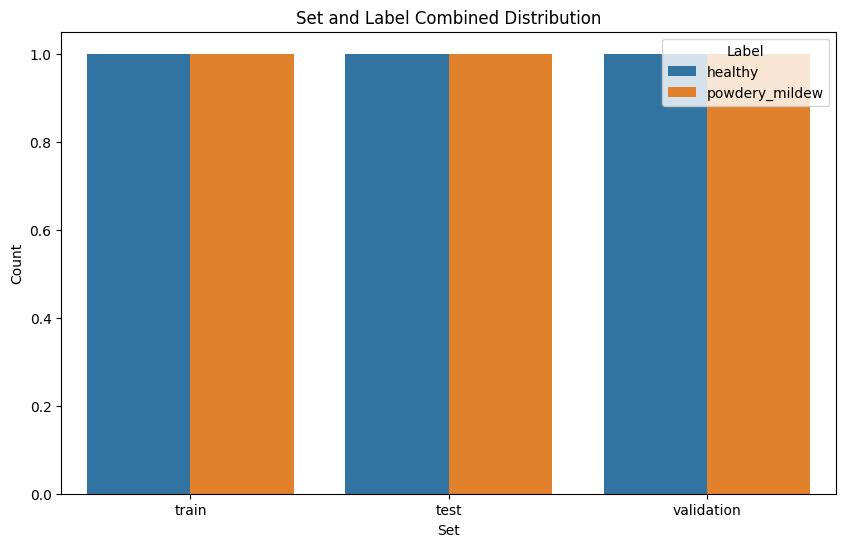

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_freq, x='Set', hue='Label')
plt.title('Set and Label Combined Distribution')
plt.xlabel('Set')
plt.ylabel('Count')
plt.legend(title='Label')
plt.show()

---

# Image data augmentation
---

## Import ImageDataGenerator

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Initialize ImageDataGenerator

In [15]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

## Set Batch Size

In [16]:
batch_size = 18

## Augment training image set

In [17]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image set

(18, 256, 256, 3)


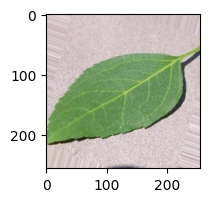

(18, 256, 256, 3)


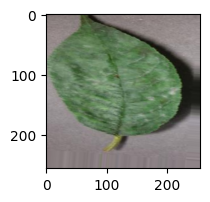

(18, 256, 256, 3)


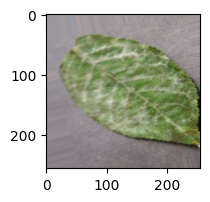

In [18]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Augment validation image set

In [19]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented validation image set

(18, 256, 256, 3)


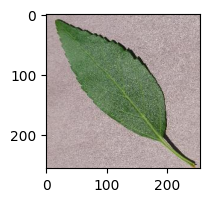

(18, 256, 256, 3)


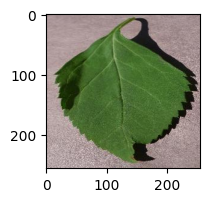

(18, 256, 256, 3)


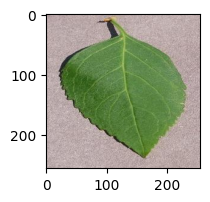

In [20]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Augment test image set

In [21]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented test image set

(18, 256, 256, 3)


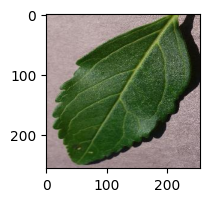

(18, 256, 256, 3)


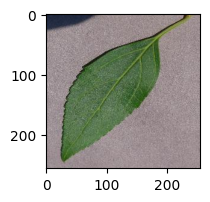

(18, 256, 256, 3)


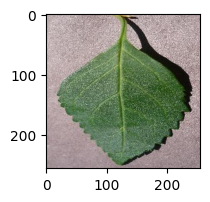

In [22]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [23]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model Creation

## Import packages

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad

## ML model

In [25]:
def create_tf_model():
    model = Sequential()

    ### input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))      
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    ### fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    ### output
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model

## Model summary

In [26]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-08-23 14:34:12.982205: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Callbacks
Callbacks are a powerful feature in machine learning, particularly when training models using libraries like TensorFlow and Keras. They provide a mechanism to control and customize the training process, allowing users to take specific actions at various stages of the training lifecycle.

### EarlyStopping & ModelCheckPoint
* EarlyStopping is used to monitor the val_accuracy (validation accuracy). 
* If the validation accuracy does not improve for a set number of epochs (patience=2 in your case), training will stop. 
* This prevents overfitting, where the model becomes too specialized on the training data and performs poorly on unseen data (like validation or test sets).
---
* ModelCheckPoint monitors the val_accuracy and saves the model with the highest validation accuracy to the file path specified (outputs/v1/powdery_mildew_model.h5)
* This ensures that you have a copy of the best-performing model, which is crucial if you want to avoid retraining the model from scratch or in case of any interruptions during training. 
* Saving only the best model also helps manage storage efficiently, especially if the training process runs for many epochs.

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

## Fit model for model training

In [28]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=32,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

2024-08-23 14:45:05.936893: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/32
163/163 [==============================] - 189s 1s/step - loss: 0.4914 - accuracy: 0.7611 - val_loss: 0.3294 - val_accuracy: 0.8500
Epoch 2/32
163/163 [==============================] - 188s 1s/step - loss: 0.3361 - accuracy: 0.8575 - val_loss: 0.2440 - val_accuracy: 0.8905
Epoch 3/32
163/163 [==============================] - 187s 1s/step - loss: 0.2617 - accuracy: 0.8886 - val_loss: 0.1803 - val_accuracy: 0.9286
Epoch 4/32
163/163 [==============================] - 188s 1s/step - loss: 0.2148 - accuracy: 0.9193 - val_loss: 0.1258 - val_accuracy: 0.9833
Epoch 5/32
163/163 [==============================] - 188s 1s/step - loss: 0.1583 - accuracy: 0.9484 - val_loss: 0.1007 - val_accuracy: 0.9857
Epoch 6/32
163/163 [==============================] - 187s 1s/step - loss: 0.1224 - accuracy: 0.9648 - val_loss: 0.0887 - val_accuracy: 0.9857
Epoch 7/32
163/163 [==============================] - 188s 1s/step - loss: 0.1056 - accuracy: 0.9761 - val_loss: 0.1056 - val_accuracy: 0.9833

## Load saved best model

In [29]:
from keras.models import load_model

load_model('outputs/v1/powdery_mildew_model.h5')

---

# Model Performance

## Model learining curve A - training and validation loss and accuracy over epochs

<Figure size 500x400 with 0 Axes>

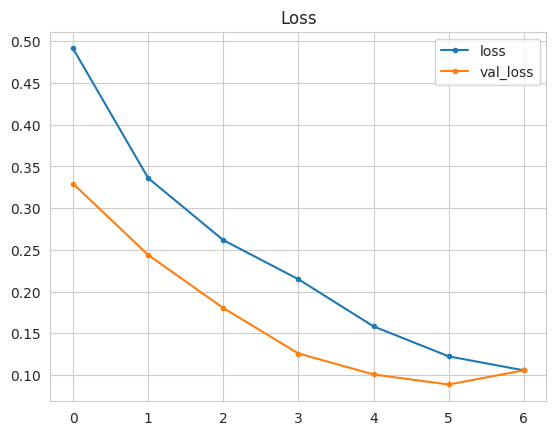

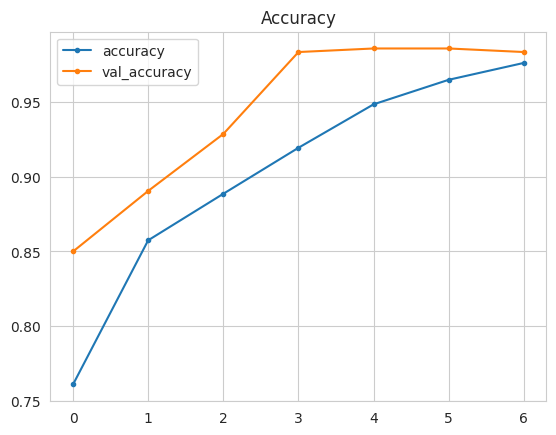

In [30]:
# Convert the model's training history to a DataFrame
losses = pd.DataFrame(model.history.history)

# Set the figure size for the plot
plt.figure(figsize=(5, 4))

# Set the style of the plot to 'whitegrid' for better aesthetics
sns.set_style("whitegrid")

# Plot training and validation loss over epochs
losses[['loss', 'val_loss']].plot(style='.-')

# Set the title of the plot
plt.title("Loss")

# Save the loss plot as a PNG image
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)

# Print a newline for better readability in the console output
print("\n")

# Plot training and validation accuracy over epochs
losses[['accuracy', 'val_accuracy']].plot(style='.-')

# Set the title of the plot
plt.title("Accuracy")

# Save the accuracy plot as a PNG image
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)

# Display the plots
plt.show()

## Model learining curve B - comprehensive view of the model's history by having all metrics in a single figure

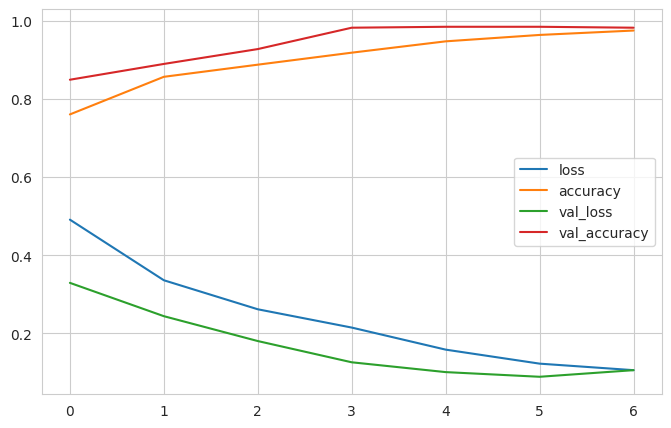

In [31]:
# Plot all metrics (loss and accuracy for both training and validation) in a single figure
pd.DataFrame(model.history.history).plot(figsize=(8,5))

# Save the combined loss and accuracy plot as a PNG image
plt.savefig(f'{file_path}/model_loss_acc.png', bbox_inches='tight', dpi=150)

# Display the plot
plt.show()

---